In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import pylab
import matplotlib
import copy
import glob as gb
import scipy.stats as st
import time
from pandas_plink import read_plink1_bin
from scipy.stats.stats import pearsonr
import sys
sys.path.append('../XPXP/src')
from utils import *

In [2]:
from multiprocessing import Pool
def worker(x):
    return os.system(x)
pool=Pool(processes=6)

In [3]:
plink_file1 = '../simulation/genodata/eas_merge_qc2_330k_noMHC'
plink_file2 = '../simulation/genodata/ukb_qc2_60k_330k_noMHC'

ref1_info = pd.read_csv(plink_file1+'.bim',sep='\t',header=None)
ref1_info.columns = ['chr','SNP','cm','bp','A1','A2']
ref2_info = pd.read_csv(plink_file2+'.bim',sep='\t',header=None)
ref2_info.columns = ['chr','SNP','cm','bp','A1','A2']
ref1_info = ref1_info.reset_index()
ref2_info = ref2_info.reset_index()

In [4]:
X1 = ReadPlink(plink_file1,ref1_info,np.int8)
X2 = ReadPlink(plink_file2,ref2_info,np.int8)

In [5]:
X1.shape, X2.shape

((32921, 330485), (60000, 330485))

In [2]:
# randomly selected 12000 samples
x1_idx = np.load('../simulation/genodata/eas_merge_qc2_12k_idx.npy')
x1_idx.shape

(12000,)

In [9]:
X1 = X1[x1_idx,:]

In [10]:
X1_stan = X1.astype(np.float32)
X1_stan = (X1_stan-X1_stan.mean(axis=0))/X1_stan.var(axis=0)**.5

In [11]:
X2_stan = X2.astype(np.float32)
X2_stan = (X2_stan-X2_stan.mean(axis=0))/X2_stan.var(axis=0)**.5

In [12]:
X1_test = X1[-2000:]

In [13]:
X1_stan.shape, X2_stan.shape, X1_test.shape

((12000, 330485), (60000, 330485), (2000, 330485))

In [19]:
def InitiaCorrMatrix(corr,nump):
    tmp = np.eye(nump)
    tmp[np.triu_indices(nump,1)]=corr
    return tmp

def GetBestPT(df,tp):
    init = 0
    initi = 0
    for i in df.iteritems():
        cor = pearsonr(i[1].values,tp)[0]
        if cor>init:
            init = cor
            initi = i[0]
    return initi,init

In [25]:
share_heri = 0.48
tansgc = 0.6
phenos = ['A','B','C']
nump = len(phenos)
EAS_pheno = BBJ_include_pheno = [_+'-EAS' for _ in phenos]
EUR_pheno = UKB_include_pheno = [_+'-EUR' for _ in phenos]
columns = BBJ_include_pheno+UKB_include_pheno

heri = np.array([share_heri for _ in range(len(columns))]) # shared heritability
true_heri = np.array([0.5 for _ in range(len(columns))])
heri_df = pd.DataFrame(heri.reshape(1,-1),columns=columns)
true_heri_df = pd.DataFrame(true_heri.reshape(1,-1),columns=columns)

corr_trans = np.full((nump,nump),corrG*tansgc)
corr_trans[np.diag_indices(nump)] = tansgc
corr_eas = corr_eur = InitiaCorrMatrix(corrG,nump)
corr_env_eas = corr_env_eur = InitiaCorrMatrix(corrE,nump)

genetic_corr = np.concatenate((np.concatenate((corr_eas,corr_trans),axis=1),np.concatenate(\
                                                (np.zeros((nump,nump)),corr_eur),axis=1)),axis=0)
genetic_corr = genetic_corr.T + genetic_corr - np.diag(np.diag(genetic_corr))
env_corr = np.concatenate((np.concatenate((corr_env_eas,np.zeros((nump,nump))),axis=1),np.concatenate(\
                                                (np.zeros((nump,nump)),corr_env_eur),axis=1)),axis=0)
env_corr = env_corr.T + env_corr - np.diag(np.diag(env_corr))
genetic_cov = np.zeros((nump*2,nump*2))
for i in range(nump*2):
    for j in range(nump*2):
        genetic_cov[i,j] = genetic_corr[i,j]*(heri[i]*heri[j])**.5
env_cov = np.zeros((nump*2,nump*2))
for i in range(nump*2):
    for j in range(nump*2):
        env_cov[i,j] = env_corr[i,j]*((1-true_heri[i])*(1-true_heri[j]))**.5
genetic_corr_df = pd.DataFrame(genetic_corr,columns=columns,index=columns)
genetic_cov_df = pd.DataFrame(genetic_cov,columns=columns,index=columns)
env_corr_df = pd.DataFrame(env_corr,columns=columns,index=columns)
env_cov_df = pd.DataFrame(env_cov,columns=columns,index=columns)

In [27]:
def PlotCorrelatin(tme_corr,tme_corr_pvalue,label,ismask=False):
    tme_corr_anno = tme_corr.round(3).astype('str').values
    star_index = tme_corr_pvalue<=(0.05)
    tme_corr_anno[star_index] += ' *'
    star_star_index = tme_corr_pvalue<=(0.05/(tme_corr_pvalue.shape[0]))
    tme_corr_anno[star_star_index] += '*'
    plt.figure(figsize=(10,10),dpi=200)
    if ismask:
        mask = np.eye(tme_corr.shape[0], dtype=np.bool)
        ax = sns.heatmap(tme_corr.T, mask=mask.T, square = True, linewidths = 2,
                              cmap='coolwarm', center=0,alpha=0.9,
            cbar_kws={"shrink": 0.6,'label':label,"orientation": "vertical"},
                         annot=tme_corr_anno.T, fmt='',annot_kws={"size": 20})
    else:
        ax = sns.heatmap(tme_corr.T,square = True, linewidths = 2,
                              cmap='coolwarm', center=0,alpha=0.9,
            cbar_kws={"shrink": 0.6,'label':label,"orientation": "vertical"},
                         annot=tme_corr_anno.T, fmt='',annot_kws={"size": 20})
    ax.tick_params(axis='y',rotation=0)
    ax.tick_params(axis='x',rotation=0)
    ax.tick_params(axis='both', which='both', length=0)
    plt.show()

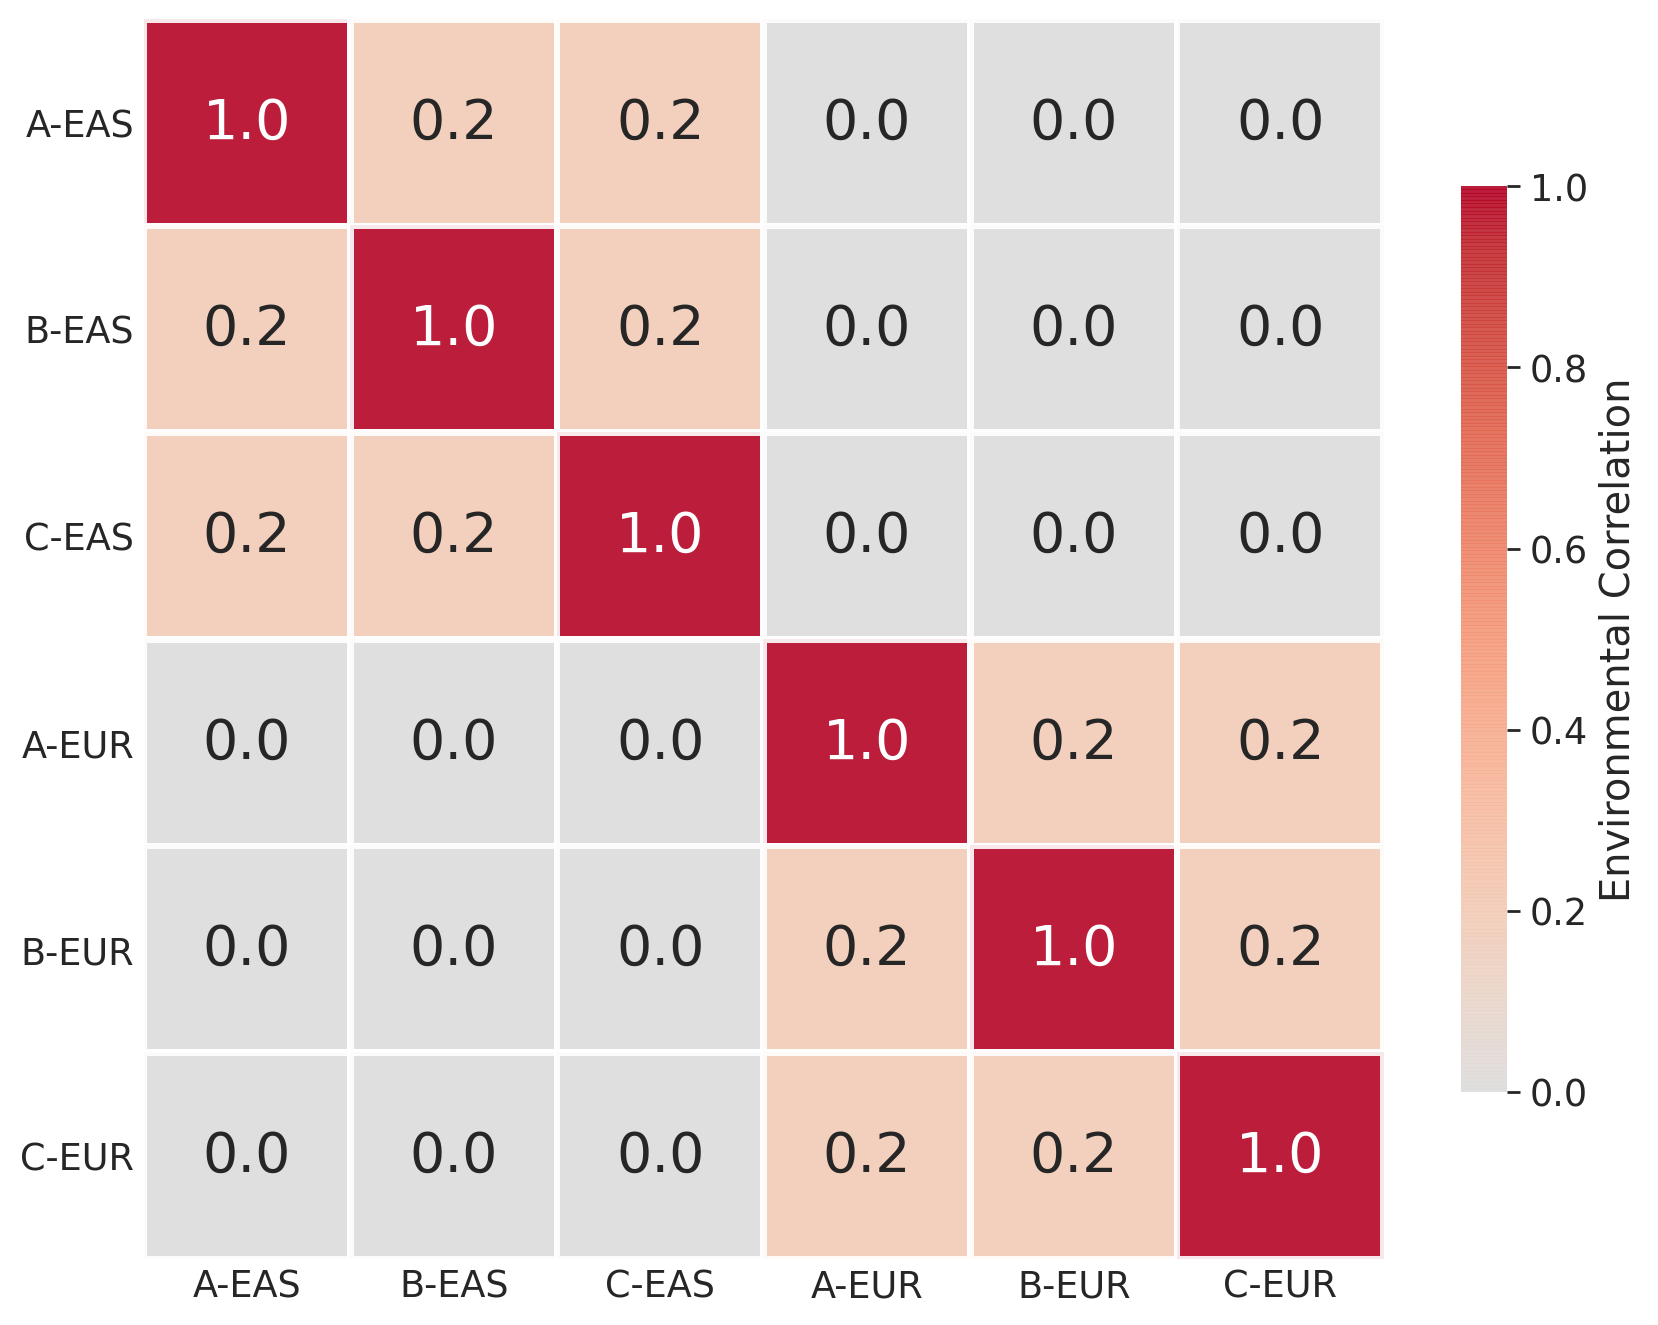

In [29]:
sns.set_context('paper',font_scale=1.5) 
PlotCorrelatin(env_corr_df,np.ones((env_corr_df.shape[0],env_corr_df.shape[1])),'Environmental Correlation',ismask=False)

## XPXP, SMTpred, LDpred-inf, P+T

In [15]:
def Simulation(rep,corrG,corrE):
    share_heri = 0.48
    tansgc = 0.6
    phenos = ['A','B','C']
    nump = len(phenos)
    EAS_pheno = BBJ_include_pheno = [_+'-EAS' for _ in phenos]
    EUR_pheno = UKB_include_pheno = [_+'-EUR' for _ in phenos]
    columns = BBJ_include_pheno+UKB_include_pheno

    heri = np.array([share_heri for _ in range(len(columns))]) # shared heritability
    true_heri = np.array([0.5 for _ in range(len(columns))])
    heri_df = pd.DataFrame(heri.reshape(1,-1),columns=columns)
    true_heri_df = pd.DataFrame(true_heri.reshape(1,-1),columns=columns)

    corr_trans = np.full((nump,nump),corrG*tansgc)
    corr_trans[np.diag_indices(nump)] = tansgc
    corr_eas = corr_eur = InitiaCorrMatrix(corrG,nump)
    corr_env_eas = corr_env_eur = InitiaCorrMatrix(corrE,nump)

    genetic_corr = np.concatenate((np.concatenate((corr_eas,corr_trans),axis=1),np.concatenate(\
                                                    (np.zeros((nump,nump)),corr_eur),axis=1)),axis=0)
    genetic_corr = genetic_corr.T + genetic_corr - np.diag(np.diag(genetic_corr))
    env_corr = np.concatenate((np.concatenate((corr_env_eas,np.zeros((nump,nump))),axis=1),np.concatenate(\
                                                    (np.zeros((nump,nump)),corr_env_eur),axis=1)),axis=0)
    env_corr = env_corr.T + env_corr - np.diag(np.diag(env_corr))
    genetic_cov = np.zeros((nump*2,nump*2))
    for i in range(nump*2):
        for j in range(nump*2):
            genetic_cov[i,j] = genetic_corr[i,j]*(heri[i]*heri[j])**.5
    env_cov = np.zeros((nump*2,nump*2))
    for i in range(nump*2):
        for j in range(nump*2):
            env_cov[i,j] = env_corr[i,j]*((1-true_heri[i])*(1-true_heri[j]))**.5
    genetic_corr_df = pd.DataFrame(genetic_corr,columns=columns,index=columns)
    genetic_cov_df = pd.DataFrame(genetic_cov,columns=columns,index=columns)
    env_corr_df = pd.DataFrame(env_corr,columns=columns,index=columns)
    env_cov_df = pd.DataFrame(env_cov,columns=columns,index=columns)
    #print(genetic_cov_df)
    #print(env_cov_df)

    n1,n2,m,meff,mleff = X1.shape[0],X2.shape[0],X1.shape[1],30000,30
    
    beta = np.load('../simulation/fix_beta/beta_G{}.npy'.format(corrG))    
    eps1 = np.random.multivariate_normal(np.zeros(nump),env_cov_df.values[:nump,:nump],n1)
    eps2 = np.random.multivariate_normal(np.zeros(nump),env_cov_df.values[nump:,nump:],n2)

    for i,p in enumerate(columns):
        ref1_info[p] = beta[:,i]

    if not os.path.exists('../simulation/reps/{}'.format(rep)):
        os.mkdir('../simulation/reps/{}'.format(rep))
    ref1_info[['chr','SNP','cm','bp','A1','A2']+columns].to_csv(\
        '../simulation/reps/{}/effect_size.txt'.format(rep),sep='\t',index=None)
    
    y1_phenos = {}
    y1 = X1_stan.dot(beta[:,:nump])+eps1
    for i,p in enumerate(phenos):
        tmp = y1[:,i]
        tmp = (tmp-tmp.mean())/tmp.var()**.5
        y1_phenos[p] = tmp
    y2 = X2_stan.dot(beta[:,nump:])+eps2
    y2_phenos = {}
    for i,p in enumerate(phenos):
        tmp = y2[:,i]
        tmp = (tmp-tmp.mean())/tmp.var()**.5
        y2_phenos[p] = tmp
        
    fam1 = pd.read_csv(plink_file1+'.fam',delim_whitespace=True,header=None)
    fam1 = fam1[[0,1]]
    fam1.columns = ['FID','IID']
    fam1 = fam1.loc[x1_idx]
    fam1 = fam1.reset_index()
    fam1 = fam1.drop('index',axis=1)
    for i,p in enumerate(phenos):
        fam1[p] = y1_phenos[p]

    fam2 = pd.read_csv(plink_file2+'.fam',delim_whitespace=True,header=None)
    fam2 = fam2[[0,1]]
    fam2.columns = ['FID','IID']
    for i,p in enumerate(phenos):
        fam2[p] = y2_phenos[p]

    fam1_train = fam1.loc[:9999,:] ##
    fam1_test = fam1.loc[10000:,:] ##
    fam1_train.shape, fam1_test.shape
    fam1_train.to_csv('../simulation/reps/{}/fam1_train.txt'.format(rep),sep='\t',index=None)
    fam1_test.to_csv('../simulation/reps/{}/fam1_test.txt'.format(rep),sep='\t',index=None)
    fam2.to_csv('../simulation/reps/{}/fam2_90k.txt'.format(rep),sep='\t',index=None)
    fam2.loc[:10000,:].to_csv('../simulation/reps/{}/fam2_20k.txt'.format(rep),sep='\t',index=None)
    fam2.loc[:20000,:].to_csv('../simulation/reps/{}/fam2_40k.txt'.format(rep),sep='\t',index=None)
    fam2.loc[:40000,:].to_csv('../simulation/reps/{}/fam2_60k.txt'.format(rep),sep='\t',index=None)

    
    os.system('/home/share/xiaojs/software/plink2 --linear \
    --bfile ../simulation/genodata/eas_merge_qc2_330k_noMHC \
    --pheno ../simulation/reps/{0}/fam1_train.txt \
    --read-freq ../simulation/genodata/eas_merge_qc2_330k_freq.frq \
    --no-parents --no-sex \
    --out ../simulation/reps/{0}/eas'.format(rep))
    for i in [20,40,60,90]:
        os.system('/home/share/xiaojs/software/plink2 --linear \
        --bfile ../simulation/genodata/ukb_qc2_90k_330k_noMHC \
        --pheno ../simulation/reps/{0}/fam2_{1}k.txt \
        --read-freq ../simulation/genodata/eas_merge_qc2_330k_freq.frq \
        --no-parents --no-sex \
        --out ../simulation/reps/{0}/eur_{1}k'.format(rep,i))
        
    for p in phenos:
        df = pd.read_csv('../simulation/reps/{0}/eas.{1}.glm.linear'.format(rep,p),sep='\t')
        df['Z'] = df.apply(lambda x:x['BETA']/x['SE'], axis=1)
        df = df[['ID','OBS_CT','ALT','REF','Z']]
        df.columns = ['SNP','N','A1','A2','Z']
        df.to_csv('../simulation/reps/{0}/{1}-EAS.txt'.format(rep,p),sep='\t',index=None)
        for i in [20,40,60,90]:
            df = pd.read_csv('../simulation/reps/{0}/eur_{1}k.{2}.glm.linear'.format(rep,i,p),sep='\t')
            df['Z'] = df.apply(lambda x:x['BETA']/x['SE'], axis=1)
            df = df[['ID','OBS_CT','ALT','REF','Z']]
            df.columns = ['SNP','N','A1','A2','Z']
            df.to_csv('../simulation/reps/{0}/{1}-EUR_{2}k.txt'.format(rep,p,i),sep='\t',index=None)
    
    
    ### Genetic Correlation
    
    f_eas = ['../simulation/reps/{0}/{1}-EAS.txt'.format(rep,p) for p in phenos]
    f_eur = ['../simulation/reps/{0}/{1}-EUR_90k.txt'.format(rep,p) for p in phenos]
    com = 'python ../XPXP/src/TransGC.py \
    --save ../simulation/reps/{0}/{1}_{2} \
    --use_snp ../simulation/genodata/used_SNPs.txt \
    --ref_files /home/share/UKB/ld_ref_2k/height_affy_ldpred_ref_2000_noMHC_300kSNPs,/home/share/UKB/ld_ref_2k/height_ukb_ldpred_ref_2000_noMHC_300kSNPs \
    --covar_files , \
    --sumst_files {3},{4}'
    coms = []
    for i,peas in enumerate(BBJ_include_pheno):
        for j,peur in enumerate(UKB_include_pheno):
            coms.append(com.format(rep,peas,peur,f_eas[i],f_eur[j]))

    output = pool.map(worker,coms)

    ldsc_com_heri = 'conda run -n ldsc python ldsc.py --h2 {0} --ref-ld-chr {1} --w-ld-chr {1} --out ../simulation/reps/{2}/{3}.log'
    ldsc_com_rg = 'conda run -n ldsc python ldsc.py --rg {0} --ref-ld-chr {1} --w-ld-chr {1} --out ../simulation/reps/{2}/{3}_{4}.log'
    for i,peas in enumerate(BBJ_include_pheno):
        os.system(ldsc_com_heri.format(f_eas[i],./XPXP_demo/eas_ldscores/,rep,peas))    
    for i,peas in enumerate(BBJ_include_pheno):
        for j,peur in enumerate(BBJ_include_pheno[(i+1):]):
            os.system(ldsc_com_rg.format(f_eas[i]+','+f_eas[j+i+1],./XPXP_demo/eas_ldscores/,rep,peas,peur))
    
    for i,peas in enumerate(UKB_include_pheno):
        os.system(ldsc_com_heri.format(f_eur[i],./XPXP_demo/eur_ldscores/,rep,peas))    
    for i,peas in enumerate(UKB_include_pheno):
        for j,peur in enumerate(UKB_include_pheno[(i+1):]):
            os.system(ldsc_com_rg.format(f_eur[i]+','+f_eur[j+i+1],./XPXP_demo/eur_ldscores/,rep,peas,peur))
    

    eas_eur_cov = np.zeros((len(BBJ_include_pheno),len(UKB_include_pheno)))
    eas_eur_corr = np.zeros((len(BBJ_include_pheno),len(UKB_include_pheno)))
    eas_heri = np.zeros(len(BBJ_include_pheno))
    eur_heri = np.zeros(len(UKB_include_pheno))

    for i,peas in enumerate(BBJ_include_pheno):
        for j,peur in enumerate(UKB_include_pheno):
            fc = '../simulation/reps/{}/{}_{}.log'.format(rep,peas,peur)
            corr = open(fc).readlines()[-2].split()[-1]
            cov = open(fc).readlines()[-2].split()[-2]
            eas_heri[i] = open(fc).readlines()[-2].split()[-4]
            eur_heri[j] = open(fc).readlines()[-2].split()[-3]
            eas_eur_cov[i,j] = cov
            eas_eur_corr[i,j] = corr
    eas_eur_cov_df = pd.DataFrame(eas_eur_cov,index=BBJ_include_pheno,columns=UKB_include_pheno)
    eas_eur_corr_df = pd.DataFrame(eas_eur_corr,index=BBJ_include_pheno,columns=UKB_include_pheno)
    eas_eur_cov_e_df = pd.DataFrame(np.zeros((len(BBJ_include_pheno),len(UKB_include_pheno))),index=BBJ_include_pheno,columns=UKB_include_pheno)
    eur_heri_df = pd.DataFrame(eur_heri,index=UKB_include_pheno,columns=['heri'])
    eas_heri_df = pd.DataFrame(eas_heri,index=BBJ_include_pheno,columns=['heri'])

    eas_eas_cov = np.zeros((len(BBJ_include_pheno),len(BBJ_include_pheno)))
    eas_eas_cov_e = np.zeros((len(BBJ_include_pheno),len(BBJ_include_pheno)))

    for i,peas in enumerate(BBJ_include_pheno):
        for j,peas2 in enumerate((BBJ_include_pheno)[i+1:]):
            fc = '../simulation/reps/{}/{}_{}.log'.format(rep,peas,peas2)
            for ln,line in enumerate(open(fc).readlines()):
                if 'gencov:' in line:
                    eas_eas_cov[i,i+1+j] = float(line.split()[-2])
                    break
            eas_eas_cov_e[i,i+1+j] = float(open(fc).readlines()[ln+2].split()[-2])-eas_eas_cov[i,i+1+j]
        eas_eas_cov[i,i] = eas_heri_df.loc[peas].values[0]
        eas_eas_cov_e[i,i] = 1-eas_heri_df.loc[peas].values[0]
    eas_eas_cov = eas_eas_cov+eas_eas_cov.T-np.diag(np.diag(eas_eas_cov))
    eas_eas_cov_e = eas_eas_cov_e+eas_eas_cov_e.T-np.diag(np.diag(eas_eas_cov_e))

    eas_eas_cov_df = pd.DataFrame(eas_eas_cov,index=EAS_pheno,columns=EAS_pheno)
    eas_eas_cov_e_df = pd.DataFrame(eas_eas_cov_e,index=EAS_pheno,columns=EAS_pheno)

    eur_eur_cov = np.zeros((len(UKB_include_pheno),len(UKB_include_pheno)))
    eur_eur_cov_e = np.zeros((len(UKB_include_pheno),len(UKB_include_pheno)))

    for i,peas in enumerate(UKB_include_pheno):
        for j,peas2 in enumerate(UKB_include_pheno[i+1:]):
            fc = '../simulation/reps/{}/{}_{}.log'.format(rep,peas,peas2)
            for ln,line in enumerate(open(fc).readlines()):
                if 'gencov:' in line:
                    eur_eur_cov[i,i+1+j] = float(line.split()[-2])
                    break
            eur_eur_cov_e[i,i+1+j] = float(open(fc).readlines()[ln+2].split()[-2])-eur_eur_cov[i,i+1+j]
        eur_eur_cov[i,i] = eur_heri_df.loc[peas].values[0]
        eur_eur_cov_e[i,i] = 1-eur_heri_df.loc[peas].values[0]
    eur_eur_cov = eur_eur_cov+eur_eur_cov.T-np.diag(np.diag(eur_eur_cov))
    eur_eur_cov_e = eur_eur_cov_e+eur_eur_cov_e.T-np.diag(np.diag(eur_eur_cov_e))

    eur_eur_cov_df = pd.DataFrame(eur_eur_cov,index=EUR_pheno,columns=EUR_pheno)
    eur_eur_cov_e_df = pd.DataFrame(eur_eur_cov_e,index=EUR_pheno,columns=EUR_pheno)

    cov_df = pd.concat((pd.concat((eas_eas_cov_df,eas_eur_cov_df),axis=1),pd.concat((eas_eur_cov_df.T,eur_eur_cov_df),axis=1)),axis=0)
    cov_e_df = pd.concat((pd.concat((eas_eas_cov_e_df,eas_eur_cov_e_df),axis=1),pd.concat((eas_eur_cov_e_df.T,eur_eur_cov_e_df),axis=1)),axis=0)

    for c1 in columns:
        for c2 in columns:
            if c1==c2:
                continue
            else:
                if cov_df.loc[c1,c2] > 0.95*(cov_df.loc[c1,c1]*cov_df.loc[c2,c2])**.5:
                    cov_df.loc[c1,c2] = 0.95*(cov_df.loc[c1,c1]*cov_df.loc[c2,c2])**.5
                elif cov_df.loc[c1,c2] < -0.95*(cov_df.loc[c1,c1]*cov_df.loc[c2,c2])**.5:
                    cov_df.loc[c1,c2] = -0.95*(cov_df.loc[c1,c1]*cov_df.loc[c2,c2])**.5
                else:
                    pass
                if cov_e_df.loc[c1,c2] > 0.95*(cov_e_df.loc[c1,c1]*cov_e_df.loc[c2,c2])**.5:
                    cov_e_df.loc[c1,c2] = 0.95*(cov_e_df.loc[c1,c1]*cov_e_df.loc[c2,c2])**.5
                elif cov_e_df.loc[c1,c2] < -0.95*(cov_e_df.loc[c1,c1]*cov_e_df.loc[c2,c2])**.5:
                    cov_e_df.loc[c1,c2] = -0.95*(cov_e_df.loc[c1,c1]*cov_e_df.loc[c2,c2])**.5
                else:
                    pass

    corr_df = cov_to_corr(cov_df)
    corr_df.to_csv('../simulation/reps/{}/gcorr_C6.csv'.format(rep))
    cov_df.to_csv('../simulation/reps/{}/gcov_C6.csv'.format(rep))
    cov_e_df.to_csv('../simulation/reps/{}/ecov_C6.csv'.format(rep))
    
    #XPXP
    
    for i in [20,40,60,90]:
        sumsfiles = ['../simulation/reps/{0}/{1}-EAS.txt'.format(rep,p) for p in phenos]+\
            ['../simulation/reps/{0}/{1}-EUR_{2}k.txt'.format(rep,p,i) for p in phenos]
        os.system('python ../XPXP/src/XPXP.py \
        --fix_effect_trait A-EAS \
        --num_threads 32 \
        --return_LDpredinf \
        --save ../simulation/reps/{0}/MT-PM-C6-{1}k.csv \
        --gc_file ../simulation/reps/{0}/gcov_C6.csv \
        --ec_file ../simulation/reps/{0}/ecov_C6.csv \
        --sumst_files {2} \
        --sumst_ss {3}+{4} \
        --ref_files /home/share/UKB/ld_ref_2k/height_affy_ldpred_ref_2000_noMHC_300kSNPs,/home/share/UKB/ld_ref_2k/height_ukb_ldpred_ref_2000_noMHC_300kSNPs \
        --use_snp ../simulation/genodata/used_SNPs.txt \
        --ld_block_file  /home/share/xiaojs/database/prs/EAS_fourier_ls-all.bed'.format(rep,i,
                                                                                       ','.join(sumsfiles),
                                                                                       ','.join(EAS_pheno),
                                                                                       ','.join(EUR_pheno)))
        
    sumsfiles = ['../simulation/reps/{0}/{1}-EAS.txt'.format(rep,p) for p in phenos]        
    os.system('python ../XPXP/src/XPXP.py \
    --fix_effect_trait A-EAS \
    --num_threads 32 \
    --save ../simulation/reps/{0}/MT-PM-W3.csv \
    --gc_file ../simulation/reps/{0}/gcov_C6.csv \
    --ec_file ../simulation/reps/{0}/ecov_C6.csv \
    --sumst_files {1} \
    --sumst_ss {2}+ \
    --ref_files /home/share/UKB/ld_ref_2k/height_affy_ldpred_ref_2000_noMHC_300kSNPs,/home/share/UKB/ld_ref_2k/height_ukb_ldpred_ref_2000_noMHC_300kSNPs \
    --use_snp ../simulation/genodata/used_SNPs.txt \
    --ld_block_file  /home/share/xiaojs/database/prs/EAS_fourier_ls-all.bed'.format(rep,','.join(sumsfiles),','.join(EAS_pheno)))


    
    ### smtpred
    heri_smt = {}
    rgs_smt = {}
    for i,peas in enumerate(BBJ_include_pheno):
        for j,peas2 in enumerate((BBJ_include_pheno)[i+1:]):
            fc = '../simulation/reps/{}/{}_{}.log'.format(rep,peas,peas2)
            tmp = pd.read_csv(fc,sep=' ')
            corr_cor_tmp = tmp['corr_corrected'].values[0]
            heri1_tmp = tmp['h2_1'].values[0]
            heri2_tmp = tmp['h2_2'].values[0]
            heri_smt[peas] = heri1_tmp
            heri_smt[peas2] = heri2_tmp
            rgs_smt[peas+'+'+peas2] = corr_cor_tmp

    with open('../simulation/reps/{0}/ns.txt'.format(rep), 'w') as f:
        for p in BBJ_include_pheno:
            f.write(p+'\t'+str(10000)+'\n')
        f.close()
    with open('../simulation/reps/{0}/h2s.txt'.format(rep), 'w') as f:
        for p in BBJ_include_pheno:
            f.write(p+'\t'+str(heri_smt[p])+'\n')
        f.close()
    with open('../simulation/reps/{0}/rgs.txt'.format(rep), 'w') as f:
        for i,p in enumerate(BBJ_include_pheno):
            for p2 in BBJ_include_pheno[i+1:]:
                f.write(p+'\t'+p2+'\t'+str(rgs_smt[p+'+'+p2])+'\n')
        f.close()

    com = 'plink \
        --bfile ../simulation/genodata/eas_merge_qc2_330k_noMHC \
        --score ../simulation/reps/{0}/MT-PM-C6-20k.csv 2 4 {1} header sum \
        --out ../simulation/reps/{0}/{2}'

    coms = []
    score_file = '../simulation/reps/{0}/MT-PM-C6-20k.csv'.format(rep)
    header = open(score_file,'r').readline().strip().split('\t')
    for p in EAS_pheno:
        col = 1+header.index('{}-mu'.format(p))
        coms.append(com.format(rep,col,p))
    output = pool.map(worker,coms)
    
    sumsfiles = ['../simulation/reps/{0}/{1}-EAS.profile'.format(rep,p) for p in phenos]   
    os.system('conda run -n ldsc python /home/share/xiaojs/software/smtpred/smtpred.py \
        --h2file ../simulation/reps/{0}/h2s.txt \
        --rgfile ../simulation/reps/{0}/rgs.txt \
        --nfile ../simulation/reps/{0}/ns.txt \
        --scorefiles {1} \
        --out ../simulation/reps/{0}/wMT-SBLUP-EAS \
        --blup'.format(rep,' '.join(sumsfiles)))
    
    n2s = [10,20,40,60] # true sample size
    for idx,i in enumerate([20,40,60,90]):
        with open('../simulation/reps/{0}/ns-{1}k.txt'.format(rep,i), 'w') as f:
            for p in BBJ_include_pheno:
                f.write(p+'\t'+str(10000)+'\n')
            for p in UKB_include_pheno:
                f.write(p+'-{}k\t'.format(i)+str(n2s[idx]*1000)+'\n')
            f.close()
        with open('../simulation/reps/{0}/h2s-{1}k.txt'.format(rep,i), 'w') as f:
            for p in BBJ_include_pheno:
                f.write(p+'\t'+str(cov_df.loc[p,p])+'\n')
            for p in UKB_include_pheno:
                f.write(p+'-{}k\t'.format(i)+str(cov_df.loc[p,p])+'\n')
            f.close()
        all_include_pheno = BBJ_include_pheno+UKB_include_pheno
        with open('../simulation/reps/{0}/rgs-{1}k.txt'.format(rep,i), 'w') as f:
            for idx,p in enumerate(all_include_pheno):
                for p2 in all_include_pheno[idx+1:]:
                    if 'EUR' in p:
                        p_name = p+'-{}k'.format(i)
                    else:
                        p_name = p
                    if 'EUR' in p2:
                        p2_name = p2+'-{}k'.format(i)
                    else:
                        p2_name = p2
                    f.write(p_name+'\t'+p2_name+'\t'+str(corr_df.loc[p,p2])+'\n')
            f.close()
    
        com = 'plink \
        --bfile ../simulation/genodata/eas_merge_qc2_330k_noMHC \
        --score ../simulation/reps/{0}/MT-PM-C6-{1}k.csv 2 4 {2} header sum \
        --out ../simulation/reps/{0}/{3}-{1}k'

        coms = []
        score_file = '../simulation/reps/{0}/MT-PM-C6-{1}k.csv'.format(rep,i)
        header = open(score_file,'r').readline().strip().split('\t')
        for p in UKB_include_pheno:
            col = 1+header.index('{}-mu'.format(p))
            coms.append(com.format(rep,i,col,p))
        output = pool.map(worker,coms)
        
        sumsfiles = ['../simulation/reps/{0}/{1}-EAS.profile'.format(rep,p) for p in phenos]+\
            ['../simulation/reps/{0}/{1}-EUR-{2}k.profile'.format(rep,p,i) for p in phenos]
        os.system('conda run -n ldsc python /home/share/xiaojs/software/smtpred/smtpred.py \
            --h2file ../simulation/reps/{0}/h2s-{1}k.txt \
            --rgfile ../simulation/reps/{0}/rgs-{1}k.txt \
            --nfile ../simulation/reps/{0}/ns-{1}k.txt \
            --scorefiles {2} \
            --out ../simulation/reps/{0}/wMT-SBLUP-All-{1}k \
            --blup'.format(rep,i,' '.join(sumsfiles)))
        
    
    ### P+T  
    pt_coms = []
    pt_coms.append('Rscript pt-method-plink-input.R \
               ../simulation/reps/{0}/eas.A.glm.linear \
               ../simulation/reps/{0}/eas.A.PTpred.txt'.format(rep))
    for i in [20,40,60,90]:
        pt_coms.append('Rscript pt-method-plink-input.R \
               ../simulation/reps/{0}/eur_{1}k.A.glm.linear \
               ../simulation/reps/{0}/eur_{1}k.A.PTpred.txt'.format(rep,i))
    output = pool.map(worker,pt_coms)


In [ ]:
for corrG in [0,0.4,0.8]:
    for corrE in [0.2]:
        for i in range(1,11):
            rep = 'v8-p3-G{}-E{}-{}'.format(corrG,corrE,i)
            try:
                Simulation(rep,corrG,corrE)
            except Exception as e:
                print(e)
                continue

## PRS-CSx

In [149]:
simu_path = '../simulation/reps/'

reformat_com1 = 'python ~/cross-popu/xpxp/reformat_ss_PRScsx.py \
--inp ../simulation/reps/{0}/A-EAS.txt \n'

prscs_com1 = 'python /home/share/xiaojs/software/PRScsx/PRScsx.py \
--ref_dir=/home/share/xiaojs/software/PRScsx/ref_data \
--bim_prefix=../simulation/genodata/eas_merge_qc2_330k_noMHC \
--sst_file=../simulation/reps/{0}/A-EAS.txt.prscsx_format.txt \
--n_gwas=10000 \
--pop=EAS  \
--n_iter=1000 \
--n_burnin=500 \
--phi=1e-2 \
--out_dir=../simulation/reps/{0} \
--out_name=PRScsx \n\n'

reformat_com2 = 'python ~/cross-popu/xpxp/reformat_ss_PRScsx.py \
--inp ../simulation/reps/{0}/A-EUR_{1}k.txt \n'

prscs_com2 = 'python /home/share/xiaojs/software/PRScsx/PRScsx.py \
--ref_dir=/home/share/xiaojs/software/PRScsx/ref_data \
--bim_prefix=../simulation/genodata/eas_merge_qc2_330k_noMHC \
--sst_file=../simulation/reps/{0}/A-EAS.txt.prscsx_format.txt,../simulation/reps/{0}/A-EUR_{1}k.txt.prscsx_format.txt \
--n_gwas=10000,{2} \
--pop=EAS,EUR  \
--n_iter=1000 \
--n_burnin=500 \
--phi=1e-2 \
--out_dir=../simulation/reps/{0} \
--out_name=PRScsx_{1}k \n\n'

In [150]:
with open('../xpxp/prscsx/prscsx_mt.sh', 'w') as f:
    f.write('#!/bin/bash \n\n')
    f.write('set -o pipefail\nset -exu \n\n')
    for gc in [0,0.4,0.8]:
        for r in range(1,11):
            rep = 'v8-p3-G{}-E0.2-{}'.format(gc,r)
            if os.path.exists(simu_path+rep):
                f.write('dt=$(date "+%d/%m/%Y %H:%M:%S")\necho "$dt"\n')
                f.write('echo '+rep+'\n\n')
                f.write(reformat_com1.format(rep))

                f.write(reformat_com2.format(rep,20))
                f.write(prscs_com2.format(rep,20,10000))

## LDpred2

In [ ]:
docker run --net=host -it \
-v ../simulation/reps:/simulation/reps \
-v /home/share/UKB/1kg_ref/maf_0.05:/home/share/UKB/1kg_ref/maf_0.05    \
-v /home/jxiaoae/cross-popu/xpxp/ldpred2.R:/ldpred2.R \
-v ../xpxp/ldpred2:/ldpred2 \
lifebitai/bigsnpr:1.0 /bin/bash
                    
export OPENBLAS_NUM_THREADS=1

In [ ]:
library(bigsnpr)
snp_readBed("1000G.EAS.QC.hm3.ind.bed")
snp_readBed("1000G.EUR.QC.hm3.ind.bed") 

In [161]:
simu_path = '../simulation/reps/'

reformat_com3 = 'python ~/cross-popu/xpxp/reformat_ss_ldpred2.py \
--inp ../simulation/reps/{0}/{1}-EAS.txt \n'
reformat_com4 = 'python ~/cross-popu/xpxp/reformat_ss_ldpred2.py \
--inp ../simulation/reps/{0}/{1}-EUR_20k.txt \n'

with open('../xpxp/ldpred2/ldpred2_format_mt.sh', 'w') as f:
    f.write('#!/bin/bash \n\n')
    f.write('set -o pipefail\nset -exu \n\n')
    for gc in [0,0.4,0.8]:
        for r in range(1,11):
            rep = 'v8-p3-G{}-E0.2-{}'.format(gc,r)
            if os.path.exists(simu_path+rep):
                f.write('dt=$(date "+%d/%m/%Y %H:%M:%S")\necho "$dt"\n')
                f.write('echo '+rep+'\n\n')
                for i in ['A','B','C']:
                    f.write('dt=$(date "+%d/%m/%Y %H:%M:%S")\necho "$dt"\n')
                    f.write(reformat_com3.format(rep,i))
                    f.write(reformat_com4.format(rep,i))

In [ ]:
ldpred2_com1 = 'Rscript /ldpred2.R \
/home/share/UKB/1kg_ref/maf_0.05/1000G.EAS.QC.hm3.ind.rds \
../simulation/reps/{0}/{1}-EAS.txt.ldpred2_format.txt \
../simulation/reps/{0}/LDpred2-beta-auto-{1}-EAS.csv  \n\n'

ldpred2_com2 = 'Rscript /ldpred2.R \
/home/share/UKB/1kg_ref/maf_0.05/1000G.EUR.QC.hm3.ind.rds \
../simulation/reps/{0}/{1}-EUR_{2}k.txt.ldpred2_format.txt \
../simulation/reps/{0}/LDpred2-beta-auto-{1}-EUR_{2}k.csv  \n\n'

In [ ]:
with open('../xpxp/ldpred2/ldpred2_run_mt.sh', 'w') as f:
    f.write('#!/bin/bash \n\n')
    f.write('set -o pipefail\nset -exu \n\n')
    for gc in [0,0.4,0.8]:
        for r in range(1,11):
            rep = 'v8-p3-G{}-E0.2-{}'.format(gc,r)
            if os.path.exists(simu_path+rep):
                f.write('dt=$(date "+%d/%m/%Y %H:%M:%S")\necho "$dt"\n')
                f.write('echo '+rep+'\n\n')
                for i in ['A','B','C']:
                    f.write('dt=$(date "+%d/%m/%Y %H:%M:%S")\necho "$dt"\n')
                    f.write(ldpred2_com1.format(rep,i))
                    f.write(ldpred2_com2.format(rep,i,20))

## multiPRS

In [693]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

def LDpred2_score_mean(rep_path):
    score = np.array([pd.read_csv(rep_path+'{}.profile'.format(i),delim_whitespace=True)['SCORESUM'].values for i in range(1,6)]).mean(axis=0)
    tmp = pd.read_csv(rep_path+'{}.profile'.format(1),delim_whitespace=True)
    tmp['SCORESUM'] = score
    return tmp

def multiPRS(X,y):
    clf = LinearRegression()
    scores = cross_val_score(clf, X, y, cv=5, scoring='r2')
    return scores.mean()

In [ ]:
prscsx_res_mt = []
prscsx_res_mt_sd = []
for gc in [0,0.4,0.8]:
    prscsx_res = []
    for r in range(1,11):
        rep = 'v8-p3-G{}-E0.2-{}'.format(gc,r)
        if os.path.exists(simu_path_xgpu+rep):
            #print(rep)
            pheno = pd.read_csv(simu_path+'{0}/fam1_test.txt'.format(rep),delim_whitespace=True)
            tmp = LDpred2_score_mean(simu_path+'{0}/LDpred2_A_EAS_pred_'.format(rep)) 
            tmp = tmp.merge(pheno[['IID','A']])
            y = tmp['A'].values
            tmp2 = LDpred2_score_mean(simu_path+'{0}/LDpred2_A_EUR_{1}k_pred_'.format(rep,20)) 
            tmp2 = tmp2.merge(pheno[['IID','A']])
            X = np.array([tmp['SCORESUM'],tmp2['SCORESUM']]).T
            for p in ['B','C']:
                tmp = LDpred2_score_mean(simu_path+'{0}/LDpred2_{1}_EAS_pred_'.format(rep,p)) 
                tmp2 = LDpred2_score_mean(simu_path+'{0}/LDpred2_{1}_EUR_{2}k_pred_'.format(rep,p,20)) 
                X = np.concatenate((X,tmp[['SCORESUM']].values),axis=1)
                X = np.concatenate((X,tmp2[['SCORESUM']].values),axis=1)
            prscsx_res.append(multiPRS(X,y))
    prscsx_res = np.array(prscsx_res)
    prscsx_res_mt.append(prscsx_res.mean())
    prscsx_res_mt_sd.append(prscsx_res.var()**.5)